# Tiny DDPM on MNIST

Tutorial-sized diffusion training on 32x32 MNIST digits with a tiny U-Net to avoid checkerboard artifacts.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from realistica import NoiseScheduler, UNet

## Configuration

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using device: {device}")

# Hyperparameters (tutorial-sized)
config = {
    'image_size': 32,
    'batch_size': 128,
    'num_epochs': 20,
    'learning_rate': 3e-4,
    'num_timesteps': 1000,
    'beta_start': 0.0001,
    'beta_end': 0.02,
    'schedule_type': 'linear',  # 'linear' or 'cosine'
    'save_interval': 5,
    'sample_interval': 5,
}

# Create output directories
os.makedirs('outputs/mnist_tiny/samples', exist_ok=True)
os.makedirs('outputs/mnist_tiny/checkpoints', exist_ok=True)



Using device: mps


## Load MNIST Dataset

In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")



Training samples: 60000


## Visualize Some Training Images

/Users/luisfcd/opt/miniconda3/envs/realistica/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


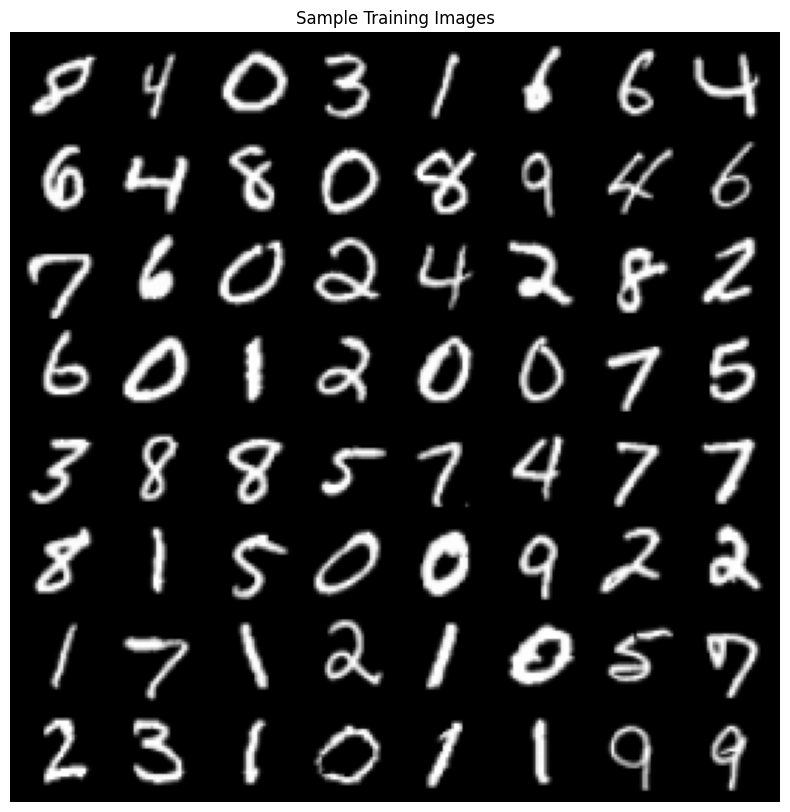

In [4]:
# Show some examples
sample_batch, _ = next(iter(train_loader))
grid = make_grid(sample_batch[:64], nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Sample Training Images')
plt.show()

## Initialize Model and Noise Scheduler

In [5]:
# Initialize noise scheduler
noise_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps'],
    beta_start=config['beta_start'],
    beta_end=config['beta_end'],
    schedule_type=config['schedule_type'],
    device=device
)

# Initialize U-Net model (tiny for MNIST)
model = UNet(
    in_channels=1,  # Grayscale
    out_channels=1,
    base_channels=32,
    channel_multipliers=(1, 2, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attention_levels=(False, False, False),
    dropout=0.0
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")



Model parameters: 1,425,793


## Visualize the Diffusion Process

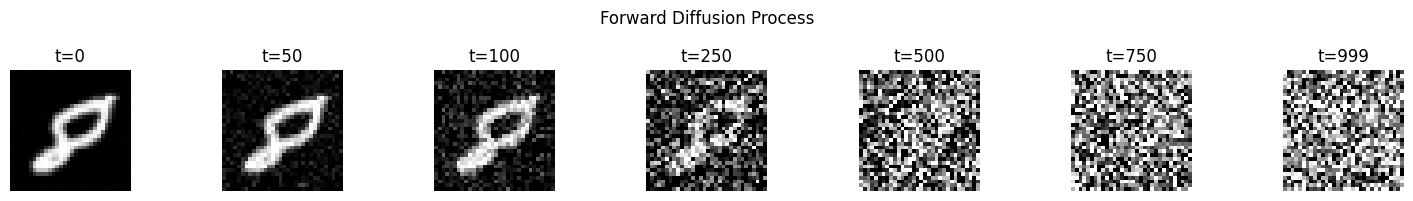

In [6]:
# Show how noise is added over time
sample_image = sample_batch[0:1].to(device)
timesteps_to_show = [0, 50, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 2))
for idx, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=device)
    noisy_image, _ = noise_scheduler.add_noise(sample_image, t_tensor)
    
    axes[idx].imshow(noisy_image[0, 0].cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[idx].set_title(f't={t}')
    axes[idx].axis('off')

plt.suptitle('Forward Diffusion Process')
plt.tight_layout()
plt.show()

## Training Loop

In [7]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Loss function (simple MSE for noise prediction)
criterion = nn.MSELoss()

# Training loop
model.train()
global_step = 0
losses = []

for epoch in range(config['num_epochs']):
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    
    for batch_idx, (images, _) in enumerate(progress_bar):
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Sample random timesteps
        t = noise_scheduler.sample_timesteps(batch_size)
        
        # Add noise to images
        noisy_images, noise = noise_scheduler.add_noise(images, t)
        
        # Predict noise
        predicted_noise = model(noisy_images, t)
        
        # Calculate loss
        loss = criterion(predicted_noise, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        epoch_loss += loss.item()
        losses.append(loss.item())
        global_step += 1
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")
    
    # Save checkpoint
    if (epoch + 1) % config['save_interval'] == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f"outputs/mnist/checkpoints/checkpoint_epoch_{epoch+1}.pt")
        print(f"Checkpoint saved at epoch {epoch+1}")

print("Training completed!")

Epoch 1/20: 100%|██████████| 469/469 [01:01<00:00,  7.66it/s, loss=0.769]


Epoch 1 - Average Loss: 0.784717


Epoch 2/20: 100%|██████████| 469/469 [00:53<00:00,  8.79it/s, loss=0.763]


Epoch 2 - Average Loss: 0.768223


Epoch 3/20: 100%|██████████| 469/469 [00:53<00:00,  8.82it/s, loss=0.76] 


Epoch 3 - Average Loss: 0.766013


Epoch 4/20: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s, loss=0.751]


Epoch 4 - Average Loss: 0.764487


Epoch 5/20: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s, loss=0.763]


Epoch 5 - Average Loss: 0.763675
Checkpoint saved at epoch 5


Epoch 6/20: 100%|██████████| 469/469 [00:53<00:00,  8.85it/s, loss=0.757]


Epoch 6 - Average Loss: 0.763082


Epoch 7/20: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s, loss=0.766]


Epoch 7 - Average Loss: 0.762509


Epoch 8/20: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, loss=0.76] 


Epoch 8 - Average Loss: 0.761903


Epoch 9/20: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, loss=0.763]


Epoch 9 - Average Loss: 0.761671


Epoch 10/20: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s, loss=0.763]


Epoch 10 - Average Loss: 0.761299
Checkpoint saved at epoch 10


Epoch 11/20: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s, loss=0.761]


Epoch 11 - Average Loss: 0.761489


Epoch 12/20: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s, loss=0.765]


Epoch 12 - Average Loss: 0.761244


Epoch 13/20: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, loss=0.758]


Epoch 13 - Average Loss: 0.761089


Epoch 14/20: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s, loss=0.765]


Epoch 14 - Average Loss: 0.761069


Epoch 15/20: 100%|██████████| 469/469 [00:52<00:00,  8.86it/s, loss=0.767]


Epoch 15 - Average Loss: 0.760835
Checkpoint saved at epoch 15


Epoch 16/20: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, loss=0.76] 


Epoch 16 - Average Loss: 0.760736


Epoch 17/20: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s, loss=0.763]


Epoch 17 - Average Loss: 0.760703


Epoch 18/20: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, loss=0.755]


Epoch 18 - Average Loss: 0.760454


Epoch 19/20: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s, loss=0.758]


Epoch 19 - Average Loss: 0.760328


Epoch 20/20: 100%|██████████| 469/469 [00:52<00:00,  8.88it/s, loss=0.763]

Epoch 20 - Average Loss: 0.760672
Checkpoint saved at epoch 20
Training completed!


## Plot Training Loss

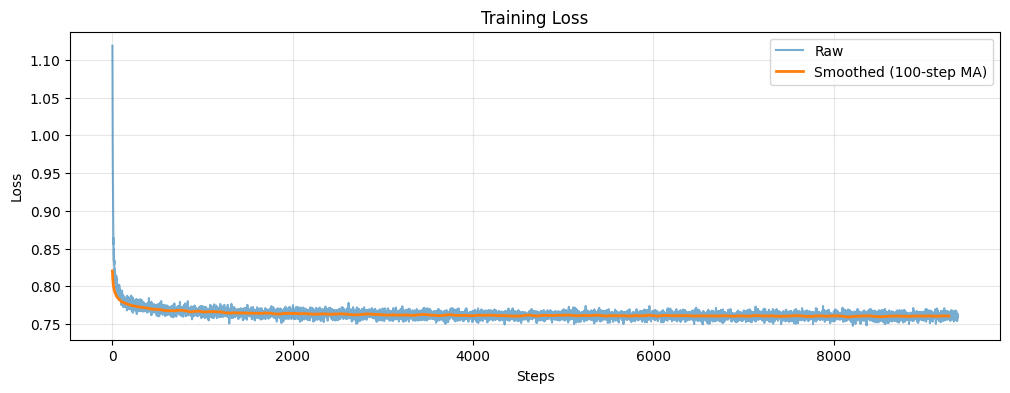

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(losses, alpha=0.6)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'), linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['Raw', 'Smoothed (100-step MA)'])
plt.grid(True, alpha=0.3)
plt.show()

## Sampling Function

In [9]:
@torch.no_grad()
def sample(model, noise_scheduler, num_samples=64, image_size=32, device='cpu'):
    """
    Generate samples using DDPM sampling
    """
    model.eval()
    
    # Start from pure noise
    x = torch.randn(num_samples, 1, image_size, image_size, device=device)
    
    # Reverse diffusion process
    for t in tqdm(reversed(range(noise_scheduler.num_timesteps)), desc='Sampling'):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Get alpha values
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        alpha_cumprod_prev = noise_scheduler.alphas_cumprod_prev[t]
        beta = noise_scheduler.betas[t]
        
        # Compute x_{t-1}
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        # DDPM sampling equation
        x = (
            1 / torch.sqrt(alpha) * (
                x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
            ) + torch.sqrt(beta) * noise
        )
    
    model.train()
    return x



## Generate Samples

Sampling: 1000it [00:24, 40.12it/s]


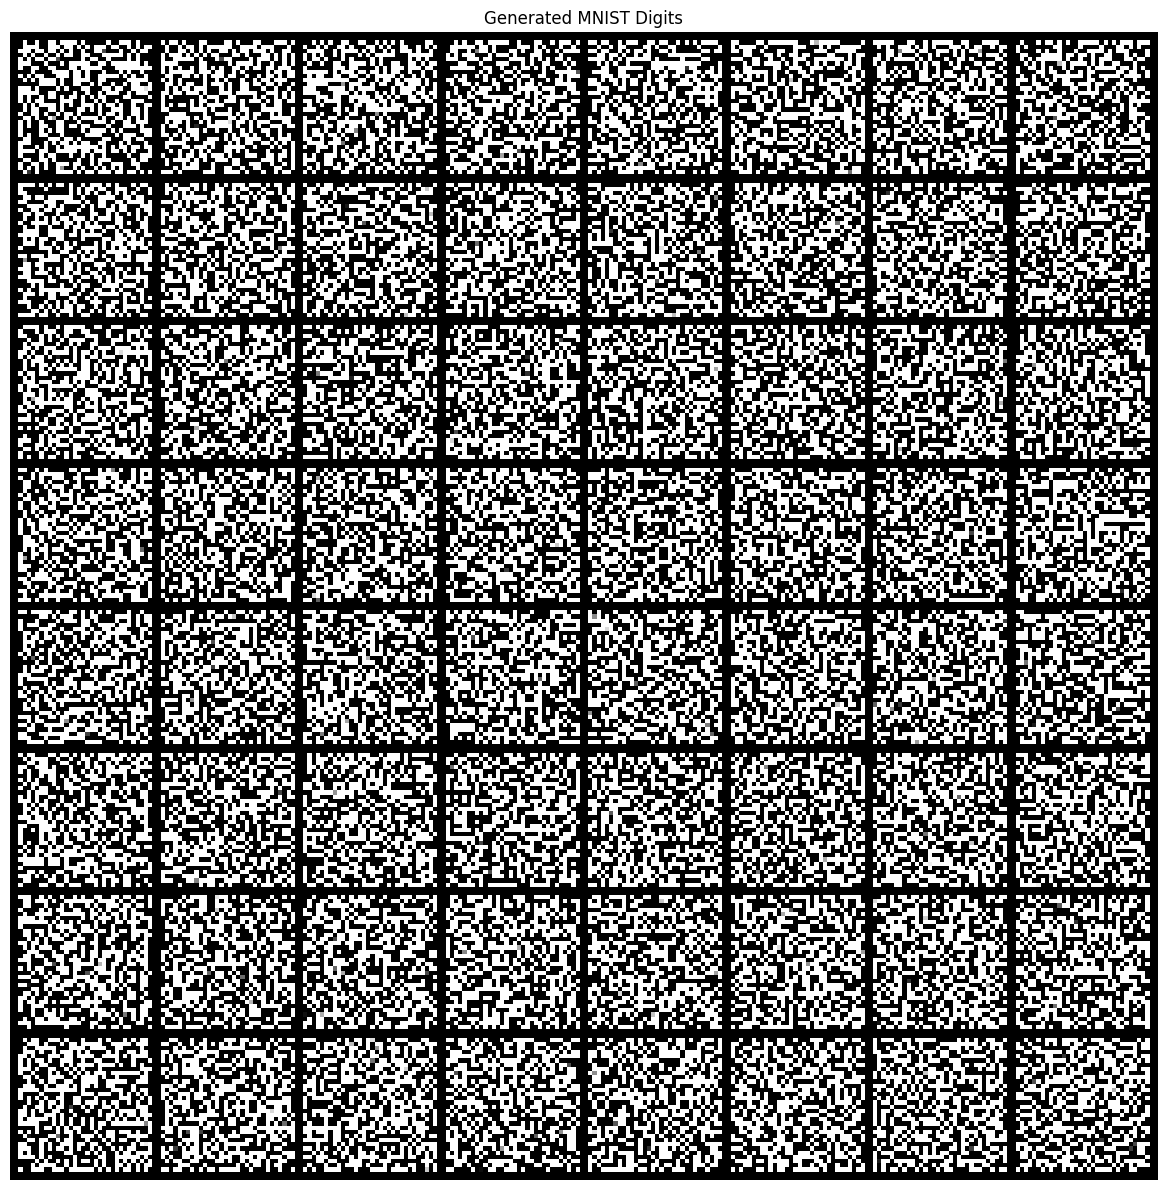

In [10]:
# Generate samples
num_samples = 64
samples = sample(
    model,
    noise_scheduler,
    num_samples=num_samples,
    image_size=config['image_size'],
    device=device
)

# Visualize generated samples
grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Generated MNIST Digits')
plt.tight_layout()
plt.savefig('outputs/mnist_tiny/samples/final_samples.png', dpi=150, bbox_inches='tight')
plt.show()



## Visualize Reverse Diffusion Process

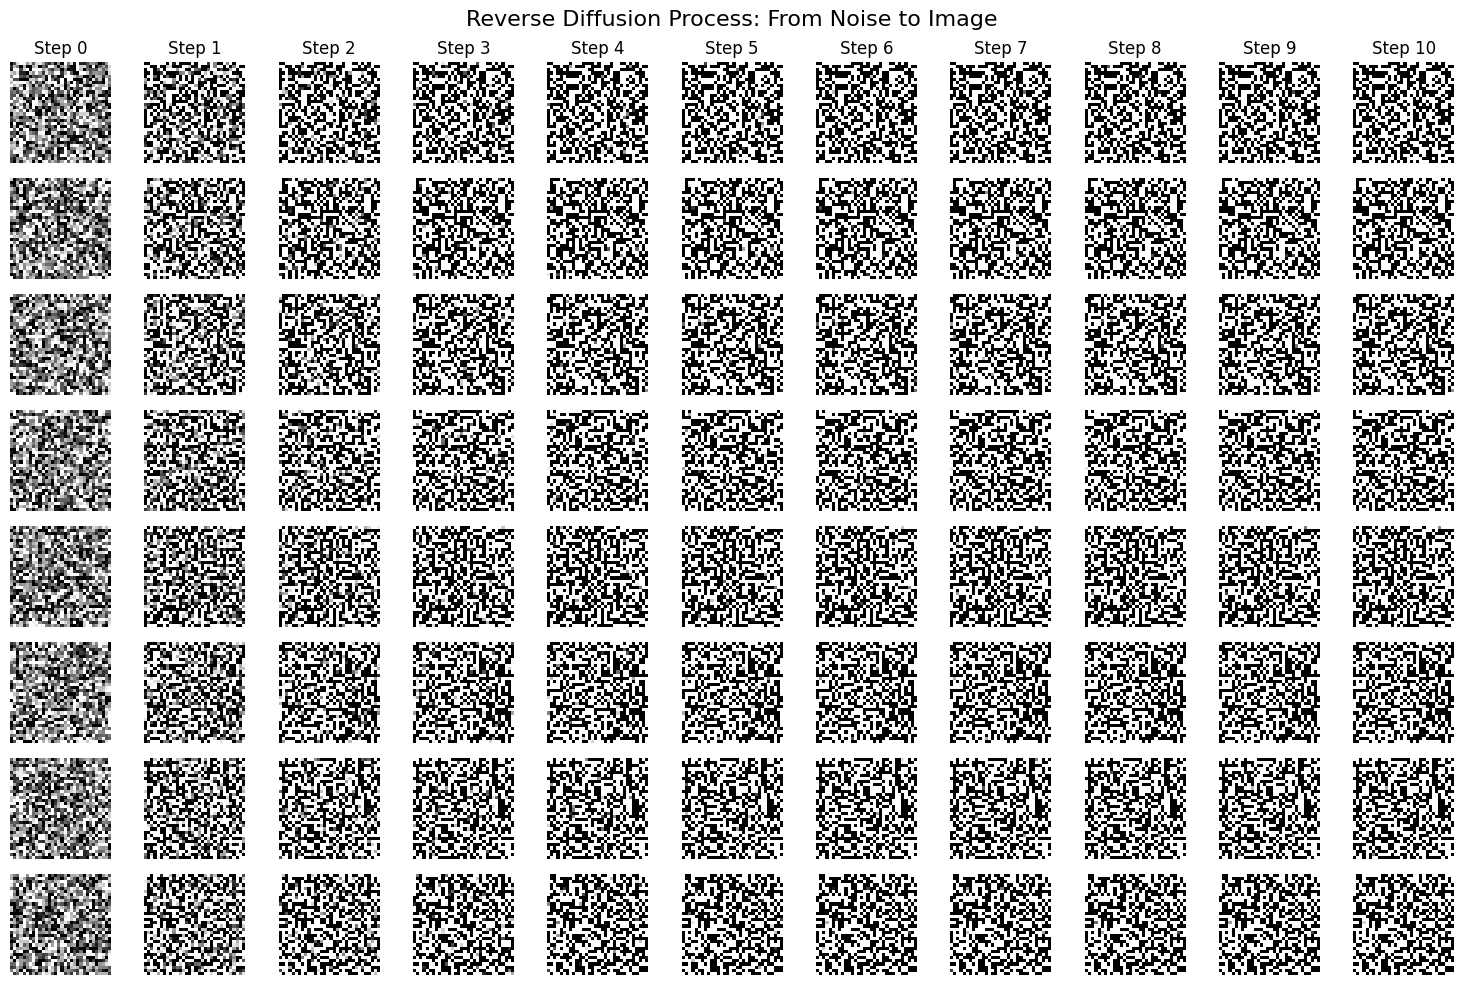

In [11]:
@torch.no_grad()
def sample_with_intermediate_steps(model, noise_scheduler, num_samples=8, image_size=32, device='cpu', steps_to_show=10):
    """
    Generate samples and return intermediate steps for visualization
    """
    model.eval()
    
    # Start from pure noise
    x = torch.randn(num_samples, 1, image_size, image_size, device=device)
    
    # Store intermediate results
    timesteps = list(reversed(range(noise_scheduler.num_timesteps)))
    step_interval = len(timesteps) // steps_to_show
    intermediate_images = []
    
    # Reverse diffusion process
    for i, t in enumerate(timesteps):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Save intermediate step
        if i % step_interval == 0 or i == len(timesteps) - 1:
            intermediate_images.append(x.cpu().clone())
        
        # Predict noise
        predicted_noise = model(x, t_batch)
        
        # Get alpha values
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        # Compute x_{t-1}
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        x = (
            1 / torch.sqrt(alpha) * (
                x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
            ) + torch.sqrt(beta) * noise
        )
    
    model.train()
    return intermediate_images

# Generate with intermediate steps
intermediate_steps = sample_with_intermediate_steps(
    model, noise_scheduler,
    num_samples=8,
    image_size=config['image_size'],
    device=device,
    steps_to_show=10
)

# Visualize the reverse process
fig, axes = plt.subplots(8, len(intermediate_steps), figsize=(15, 10))
for sample_idx in range(8):
    for step_idx, step_images in enumerate(intermediate_steps):
        img = step_images[sample_idx, 0]
        axes[sample_idx, step_idx].imshow(img.numpy(), cmap='gray', vmin=-1, vmax=1)
        axes[sample_idx, step_idx].axis('off')
        if sample_idx == 0:
            axes[sample_idx, step_idx].set_title(f'Step {step_idx}')

plt.suptitle('Reverse Diffusion Process: From Noise to Image', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/mnist_tiny/samples/reverse_diffusion.png', dpi=150, bbox_inches='tight')
plt.show()



## Save Final Model

In [12]:
# Save the final trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
}, 'outputs/mnist_tiny/checkpoints/final_model.pt')

print("Final model saved!")



Final model saved!
